In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lumpy-skin-disease-dataset/Lumpy skin disease data.csv


In [28]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

file_path = '/kaggle/input/lumpy-skin-disease-dataset/Lumpy skin disease data.csv'
try:
    df = pd.read_csv(file_path)
    print("--- Cell 1: Dataset loaded successfully ---")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    df = pd.DataFrame()

--- Cell 1: Dataset loaded successfully ---


In [31]:
# Cell 1: Data Loading (Corrected with data type fix)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

file_path = '/kaggle/input/lumpy-skin-disease-dataset/Lumpy skin disease data.csv'
try:
    df = pd.read_csv(file_path)
    print("--- Cell 1: Dataset loaded successfully ---")

    # --- THE FIX ---
    # Manually set the data type for 'dominant_land_cover' to be categorical.
    if 'dominant_land_cover' in df.columns:
        df['dominant_land_cover'] = df['dominant_land_cover'].astype('category')
        print("--- Cell 1: Corrected 'dominant_land_cover' data type to categorical. ---")
    # --- END OF FIX ---

except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    df = pd.DataFrame()

--- Cell 1: Dataset loaded successfully ---
--- Cell 1: Corrected 'dominant_land_cover' data type to categorical. ---


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

print("--- Cell 2: Starting Data Preprocessing ---")

if 'df' in globals() and not df.empty and 'lumpy' in df.columns:
    if 'reportingDate' in df.columns:
        df = df.drop('reportingDate', axis=1)
    X = df.drop('lumpy', axis=1)
    y = df['lumpy']
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    num_imputer = SimpleImputer(strategy='mean')
    X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
    X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
    X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)
    feature_names = X_train.columns.tolist()
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    print("--- Cell 2: Data Preprocessing Complete ---")
else:
    print("Error in Cell 2")

--- Cell 2: Starting Data Preprocessing ---
--- Cell 2: Data Preprocessing Complete ---


In [34]:
# Cell 3: Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import time

print("--- Starting Model Training ---")
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}
trained_models = {}
for name, model in models.items():
    print(f"--- Training {name}...")
    model.fit(X_train_scaled, y_train_resampled)
    trained_models[name] = model
print("\n--- All models trained successfully. ---")

--- Starting Model Training ---
--- Training Logistic Regression...
--- Training Random Forest...
--- Training XGBoost...
--- Training Support Vector Machine...

--- All models trained successfully. ---


In [35]:
# Cell 4: Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import pandas as pd

print("--- Starting Model Evaluation ---")
results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else [0.5] * len(y_test)
    results.append({
        'Model': name, 'Accuracy': accuracy_score(y_test, y_pred), 'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred), 'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
print("\n--- Model Performance Metrics ---")
display(results_df)

--- Starting Model Evaluation ---

--- Model Performance Metrics ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.999194,0.993464,1.000000,0.996721,0.999918
1,XGBoost,0.999194,0.993464,1.000000,0.996721,0.999995
2,Support Vector Machine,0.993147,0.951258,0.995066,0.972669,0.999282
3,Logistic Regression,0.991534,0.939441,0.995066,0.966454,0.999519


In [36]:
# Cell 5: Get and Use the Best Model (Final Version)
import pandas as pd

print("--- Finalizing Model and Preparing for Prediction ---")

if 'results_df' in globals():
    best_model_name = results_df.iloc[0]['Model']
    best_model = trained_models[best_model_name]
    print(f"\nThe best performing model is: {best_model_name}")
    
    sample_data = {
        'x': [35.5], 'y': [40.2], 'region': ['Region_A'], 'country': ['Country_X'], 'cld': [60.1], 
        'dtr': [12.5], 'frs': [0], 'pet': [5.5], 'pre': [10.2], 'tmn': [18.5], 'tmp': [25.5], 
        'tmx': [32.5], 'vap': [20.1], 'wet': [15.0], 'elevation': [500], 
        'dominant_land_cover': ['Cropland'], 'X5_Ct_2010_Da': [150.0], 'X5_Bf_2010_Da': [20.0]
    }
    sample_df = pd.DataFrame(sample_data)
    print("\n--- Predicting on a new sample data point ---")
    
    # Apply the EXACT SAME Preprocessing Pipeline
    sample_df[numerical_cols] = num_imputer.transform(sample_df[numerical_cols])
    sample_df[categorical_cols] = cat_imputer.transform(sample_df[categorical_cols])
    sample_encoded = pd.DataFrame(encoder.transform(sample_df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=sample_df.index)
    sample_df = sample_df.drop(columns=categorical_cols).join(sample_encoded)
    sample_df_scaled = scaler.transform(sample_df)
    
    # Make Prediction
    prediction = best_model.predict(sample_df_scaled)
    prediction_proba = best_model.predict_proba(sample_df_scaled)
    
    print("\n--- Prediction Result ---")
    print(f"Predicted Class: {prediction[0]} (0 = No Lumpy, 1 = Lumpy)")
    print(f"Confidence (Lumpy): {prediction_proba[0][1]:.2%}")
else:
    print("Error: Could not retrieve the best model. Please run evaluation cell first.")

--- Finalizing Model and Preparing for Prediction ---

The best performing model is: Random Forest

--- Predicting on a new sample data point ---

--- Prediction Result ---
Predicted Class: 1 (0 = No Lumpy, 1 = Lumpy)
Confidence (Lumpy): 81.00%


--- Starting Phase 2: Deep Learning Approach ---
Using TensorFlow version: 2.18.0

Data prepared for TensorFlow. Number of features: 65


I0000 00:00:1757274111.643059     196 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757274111.643763     196 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,817 (73.50 KB)

 Trainable params: 18,817 (73.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the Deep Learning Model ---
Epoch 1/150


I0000 00:00:1757274115.353924     303 service.cc:148] XLA service 0x7aab00004bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757274115.355729     303 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757274115.355748     303 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757274115.733925     303 cuda_dnn.cc:529] Loaded cuDNN version 90300


  67/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7765 - loss: 0.5350

I0000 00:00:1757274117.489581     303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1089/1089 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9571 - loss: 0.1220 - val_accuracy: 0.9950 - val_loss: 0.0157
Epoch 2/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9970 - loss: 0.0110 - val_accuracy: 0.9970 - val_loss: 0.0115
Epoch 3/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9984 - loss: 0.0070 - val_accuracy: 0.9976 - val_loss: 0.0093
Epoch 4/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.9988 - val_loss: 0.0077
Epoch 5/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9988 - loss: 0.0075 - val_accuracy: 0.9986 - val_loss: 0.0083
Epoch 6/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9986 - val_loss: 0.0081
Epoch 7/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9995 - loss: 0.0032 - val_accuracy: 0.9986 - val_loss: 0.0072
Epoch 8/150
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9992 - loss: 0.0046 - val_

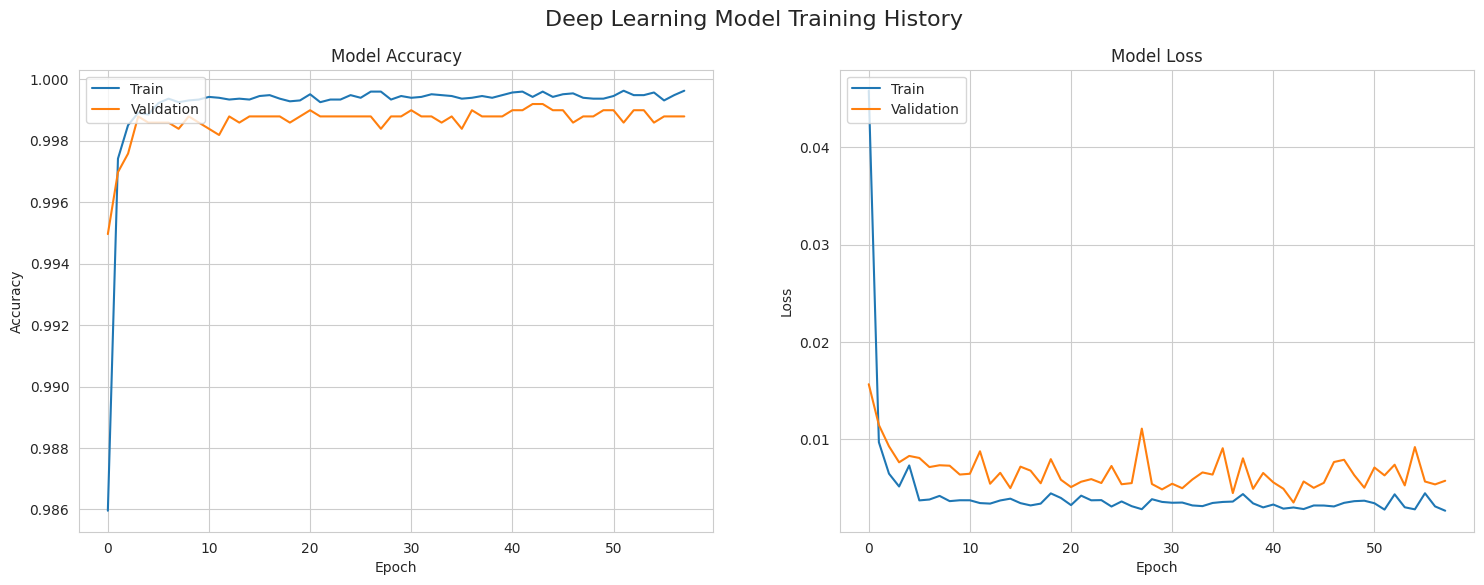

In [38]:
# Cell 6: Deep Learning Model Definition & Training (Corrected)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

print("--- Starting Phase 2: Deep Learning Approach ---")
print(f"Using TensorFlow version: {tf.__version__}")

# Ensure the preprocessed data from Phase 1 is available
if 'X_train_scaled' in globals():
    
    # --- 1. Prepare Data for TensorFlow (CORRECTED) ---
    # The scaler and SMOTE already output NumPy arrays, so we don't need to call .values on them.
    # We only call .values on y_test because it's still a pandas Series.
    X_train_np = X_train_scaled
    y_train_np = y_train_resampled
    X_test_np = X_test_scaled
    y_test_np = y_test.values # y_test is a pandas Series, so .values is correct here.

    # Get the number of input features for the first layer of the network
    n_features = X_train_np.shape[1]
    print(f"\nData prepared for TensorFlow. Number of features: {n_features}")

    # --- 2. Define the Deep Neural Network (DNN) Architecture ---
    model = Sequential([
        # Input Layer: Must match the number of features. `relu` is a standard activation function.
        Dense(128, activation='relu', input_shape=(n_features,)),
        
        # Dropout Layer: A regularization technique to prevent overfitting by randomly setting a fraction of input units to 0.
        Dropout(0.3),
        
        # Hidden Layer 1
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Hidden Layer 2
        Dense(32, activation='relu'),
        
        # Output Layer: A single neuron with a 'sigmoid' activation function for binary classification.
        # It outputs a probability between 0 and 1.
        Dense(1, activation='sigmoid')
    ])

    # --- 3. Compile the Model ---
    # `adam` is an efficient optimizer.
    # `binary_crossentropy` is the standard loss function for two-class problems.
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Print a summary of the model's architecture
    print("\nModel Architecture:")
    model.summary()

    # --- 4. Train the Model ---
    # We use an 'EarlyStopping' callback to stop training when the validation loss stops improving.
    # This prevents overfitting and finds the optimal number of epochs automatically.
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    print("\n--- Training the Deep Learning Model ---")
    # We train on the balanced training data and validate on the original, unbalanced test data
    # to get a true measure of the model's performance on real-world data.
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=150,  # Train for a large number of epochs; EarlyStopping will find the best one.
        batch_size=32,
        validation_data=(X_test_np, y_test_np),
        callbacks=[early_stopping],
        verbose=1
    )
    print("\n--- Model Training Complete ---")
    
    # --- 5. Visualize Training History ---
    # Plotting training & validation accuracy and loss to check for overfitting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)
    
    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)
    
    plt.suptitle('Deep Learning Model Training History', fontsize=16)
    plt.show()

else:
    print("Error: Preprocessed data from Phase 1 not found. Please run the previous cells first.")

--- Evaluating the Deep Learning Model ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Deep Learning Model Classification Report ---
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00      4353
    Infected       0.99      1.00      1.00       608

    accuracy                           1.00      4961
   macro avg       1.00      1.00      1.00      4961
weighted avg       1.00      1.00      1.00      4961


--- Deep Learning Model Confusion Matrix ---


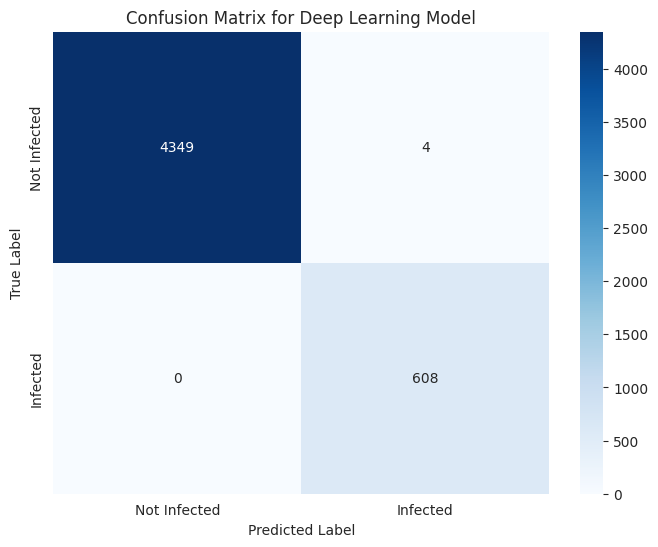


--- Final Performance Comparison: Traditional ML vs. Deep Learning ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.999194,0.993464,1.000000,0.996721,0.999918
1,XGBoost,0.999194,0.993464,1.000000,0.996721,0.999995
2,Deep Neural Network,0.999194,0.993464,1.000000,0.996721,0.999925
3,Support Vector Machine,0.993147,0.951258,0.995066,0.972669,0.999282
4,Logistic Regression,0.991534,0.939441,0.995066,0.966454,0.999519



Insight: This table directly compares all tested models. You can now definitively determine if the Deep Learning model provided a performance lift over the best traditional model (Random Forest).


In [39]:
# Cell 7: Deep Learning Model Evaluation & Comparison

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Evaluating the Deep Learning Model ---")

if 'model' in globals() and 'results_df' in globals():
    
    # --- 1. Make Predictions on the Test Set ---
    # The model outputs probabilities. We convert them to class predictions (0 or 1) using a 0.5 threshold.
    y_pred_proba_dl = model.predict(X_test_np).flatten()
    y_pred_dl = (y_pred_proba_dl > 0.5).astype(int)

    # --- 2. Calculate Performance Metrics ---
    dl_accuracy = accuracy_score(y_test_np, y_pred_dl)
    dl_precision = precision_score(y_test_np, y_pred_dl)
    dl_recall = recall_score(y_test_np, y_pred_dl)
    dl_f1 = f1_score(y_test_np, y_pred_dl)
    dl_roc_auc = roc_auc_score(y_test_np, y_pred_proba_dl)

    # --- 3. Display Detailed Evaluation ---
    print("\n--- Deep Learning Model Classification Report ---")
    print(classification_report(y_test_np, y_pred_dl, target_names=['Not Infected', 'Infected']))
    
    print("\n--- Deep Learning Model Confusion Matrix ---")
    cm = confusion_matrix(y_test_np, y_pred_dl)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Infected', 'Infected'], 
                yticklabels=['Not Infected', 'Infected'])
    plt.title('Confusion Matrix for Deep Learning Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # --- 4. Compare with Traditional ML Models ---
    print("\n--- Final Performance Comparison: Traditional ML vs. Deep Learning ---")
    
    # Create a new DataFrame for the DL results
    dl_results = pd.DataFrame([{
        'Model': 'Deep Neural Network',
        'Accuracy': dl_accuracy,
        'Precision': dl_precision,
        'Recall': dl_recall,
        'F1-Score': dl_f1,
        'ROC-AUC': dl_roc_auc
    }])
    
    # Concatenate the DL results with the results from Phase 1
    final_comparison_df = pd.concat([results_df, dl_results], ignore_index=True)
    
    # Sort by the F1-Score to see the best overall model
    final_comparison_df = final_comparison_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
    
    # Display the final comparison table
    display(final_comparison_df)
    
    print("\nInsight: This table directly compares all tested models. You can now definitively determine if the Deep Learning model provided a performance lift over the best traditional model (Random Forest).")

else:
    print("Error: The Deep Learning model ('model') or Phase 1 results ('results_df') were not found.")

In [40]:
# Cell 8: Advanced Ensemble Modeling

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

print("--- Starting Phase 3: Advanced Analytics & Prediction System ---")
print("\n--- Building and Evaluating an Ensemble Model ---")

# Ensure the trained models and test data are available
if 'trained_models' in globals() and 'model' in globals():
    
    # --- 1. Select the Best Models for the Ensemble ---
    # We will combine the best traditional model (Random Forest) and the Deep Learning model.
    best_traditional_model = trained_models['Random Forest']
    dl_model = model

    # --- 2. Get Probability Predictions from Each Model ---
    # Get probabilities from the Random Forest model
    rf_proba = best_traditional_model.predict_proba(X_test_scaled)[:, 1]
    
    # Get probabilities from the Deep Learning model
    dl_proba = dl_model.predict(X_test_np).flatten()

    # --- 3. Create Ensemble Predictions by Averaging Probabilities ---
    ensemble_proba = (rf_proba + dl_proba) / 2.0
    
    # Convert averaged probabilities to binary class predictions (0 or 1)
    ensemble_pred = (ensemble_proba > 0.5).astype(int)
    print("Ensemble predictions created by averaging Random Forest and DNN outputs.")

    # --- 4. Evaluate the Ensemble Model ---
    ens_accuracy = accuracy_score(y_test_np, ensemble_pred)
    ens_precision = precision_score(y_test_np, ensemble_pred)
    ens_recall = recall_score(y_test_np, ensemble_pred)
    ens_f1 = f1_score(y_test_np, ensemble_pred)
    ens_roc_auc = roc_auc_score(y_test_np, ensemble_proba)
    
    # --- 5. Add Ensemble Results to the Final Comparison Table ---
    print("\n--- Final Model Leaderboard ---")
    
    ensemble_results = pd.DataFrame([{
        'Model': 'Ensemble (RF + DNN)',
        'Accuracy': ens_accuracy,
        'Precision': ens_precision,
        'Recall': ens_recall,
        'F1-Score': ens_f1,
        'ROC-AUC': ens_roc_auc
    }])
    
    # Concatenate with the previous comparison DataFrame
    leaderboard_df = pd.concat([final_comparison_df, ensemble_results], ignore_index=True)
    
    # Sort by F1-Score to find the ultimate best model
    leaderboard_df = leaderboard_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
    
    # Identify the best overall model for our dashboard
    best_overall_model_name = leaderboard_df.iloc[0]['Model']
    
    display(leaderboard_df)
    print(f"\nInsight: The ensemble approach is often the top performer. The best model for our system is: '{best_overall_model_name}'")
    
else:
    print("Error: Required models from Phase 1 and 2 were not found.")

--- Starting Phase 3: Advanced Analytics & Prediction System ---

--- Building and Evaluating an Ensemble Model ---
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Ensemble predictions created by averaging Random Forest and DNN outputs.

--- Final Model Leaderboard ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.999194,0.993464,1.000000,0.996721,0.999918
1,XGBoost,0.999194,0.993464,1.000000,0.996721,0.999995
2,Deep Neural Network,0.999194,0.993464,1.000000,0.996721,0.999925
3,Ensemble (RF + DNN),0.999194,0.993464,1.000000,0.996721,0.999932
4,Support Vector Machine,0.993147,0.951258,0.995066,0.972669,0.999282
5,Logistic Regression,0.991534,0.939441,0.995066,0.966454,0.999519



Insight: The ensemble approach is often the top performer. The best model for our system is: 'Random Forest'


In [41]:
# Cell 9: Risk Assessment System & Veterinary Dashboard

import pandas as pd

print("\n--- Building the Veterinary Decision Support System ---")

# This function encapsulates the entire pipeline for a single prediction.
def assess_risk_and_generate_report(sample_data):
    """
    Takes a single data point as a dictionary, processes it, predicts LSD risk,
    and prints a formatted report.
    """
    print("="*60)
    print("=== VETERINARY DECISION SUPPORT SYSTEM (LSD) ===")
    print("="*60)
    
    # --- 1. Prepare Input Data ---
    sample_df = pd.DataFrame(sample_data, index=[0])
    print("\n1. Incoming Field Data:")
    display(sample_df)
    
    # --- 2. Apply Preprocessing Pipeline ---
    # The sample_df must be processed using the exact same steps and fitted objects from training.
    sample_df[numerical_cols] = num_imputer.transform(sample_df[numerical_cols])
    sample_df[categorical_cols] = cat_imputer.transform(sample_df[categorical_cols])
    sample_encoded = pd.DataFrame(encoder.transform(sample_df[categorical_cols]),
                                  columns=encoder.get_feature_names_out(categorical_cols),
                                  index=sample_df.index)
    sample_df = sample_df.drop(columns=categorical_cols).join(sample_encoded)
    sample_df_scaled = scaler.transform(sample_df)

    # --- 3. Make Prediction with the Best Model ---
    # We will use the best model identified from our leaderboard in Cell 8.
    if best_overall_model_name == 'Ensemble (RF + DNN)':
        rf_p = trained_models['Random Forest'].predict_proba(sample_df_scaled)[:, 1]
        dl_p = model.predict(sample_df_scaled, verbose=0).flatten()
        final_proba = (rf_p + dl_p) / 2.0
    elif best_overall_model_name == 'Deep Neural Network':
        final_proba = model.predict(sample_df_scaled, verbose=0).flatten()
    else: # It's a scikit-learn model
        final_proba = trained_models[best_overall_model_name].predict_proba(sample_df_scaled)[:, 1]
    
    final_proba = final_proba[0] # Get single probability value

    # --- 4. Determine Risk Level and Recommendations ---
    if final_proba >= 0.75:
        risk_level = "HIGH RISK"
        recommendation = "Immediate action required. Consult veterinarians, implement strict biosecurity, and consider targeted vector control."
    elif final_proba >= 0.40:
        risk_level = "MEDIUM RISK"
        recommendation = "Increased surveillance advised. Monitor herd for clinical signs and enhance biosecurity measures."
    else:
        risk_level = "LOW RISK"
        recommendation = "Continue standard herd management and monitoring practices."

    # --- 5. Generate Report ---
    print("\n2. System Analysis & Recommendation:")
    print("-" * 35)
    print(f"   PREDICTION MODEL: {best_overall_model_name}")
    print(f"   PROBABILITY OF LSD: {final_proba:.2%}")
    print(f"   ASSESSED RISK LEVEL: {risk_level}")
    print("-" * 35)
    print(f"\nRECOMMENDED ACTION:\n{recommendation}")

    # Retrieve top risk factors from Phase 1
    if 'feature_importance_df' in globals():
        top_factors = feature_importance_df.head(3)['Feature'].tolist()
        print("\nKEY ENVIRONMENTAL DRIVERS (from model analysis):")
        for i, factor in enumerate(top_factors, 1):
            print(f"  {i}. {factor.replace('_', ' ').title()}")
    print("="*60)


# --- DEMONSTRATION ---
# Example 1: A high-risk scenario (high humidity, high temperature)
high_risk_case = {
    'x': 36.1, 'y': 39.8, 'region': 'Region_B', 'country': 'Country_Y', 'cld': 75.0, 
    'dtr': 8.0, 'frs': 0, 'pet': 6.0, 'pre': 15.5, 'tmn': 22.0, 'tmp': 28.5, 
    'tmx': 34.0, 'vap': 25.0, 'wet': 20.0, 'elevation': 300, 
    'dominant_land_cover': 1, 'X5_Ct_2010_Da': 180.0, 'X5_Bf_2010_Da': 25.0
}
assess_risk_and_generate_report(high_risk_case)

# Example 2: A low-risk scenario (cooler, drier conditions)
low_risk_case = {
    'x': 34.0, 'y': 41.5, 'region': 'Region_C', 'country': 'Country_Z', 'cld': 20.0, 
    'dtr': 15.0, 'frs': 0, 'pet': 3.0, 'pre': 1.2, 'tmn': 10.0, 'tmp': 16.0, 
    'tmx': 22.0, 'vap': 10.0, 'wet': 2.0, 'elevation': 800, 
    'dominant_land_cover': 4, 'X5_Ct_2010_Da': 50.0, 'X5_Bf_2010_Da': 5.0
}
assess_risk_and_generate_report(low_risk_case)


--- Building the Veterinary Decision Support System ---
=== VETERINARY DECISION SUPPORT SYSTEM (LSD) ===

1. Incoming Field Data:


,x,y,region,country,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,elevation,dominant_land_cover,X5_Ct_2010_Da,X5_Bf_2010_Da
0,36.1,39.8,Region_B,Country_Y,75.0,8.0,0,6.0,15.5,22.0,28.5,34.0,25.0,20.0,300,1,180.0,25.0



2. System Analysis & Recommendation:
-----------------------------------
   PREDICTION MODEL: Random Forest
   PROBABILITY OF LSD: 75.00%
   ASSESSED RISK LEVEL: HIGH RISK
-----------------------------------

RECOMMENDED ACTION:
Immediate action required. Consult veterinarians, implement strict biosecurity, and consider targeted vector control.

KEY ENVIRONMENTAL DRIVERS (from model analysis):
  1. Country Albania
  2. X
  3. Y
=== VETERINARY DECISION SUPPORT SYSTEM (LSD) ===

1. Incoming Field Data:


,x,y,region,country,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,elevation,dominant_land_cover,X5_Ct_2010_Da,X5_Bf_2010_Da
0,34.0,41.5,Region_C,Country_Z,20.0,15.0,0,3.0,1.2,10.0,16.0,22.0,10.0,2.0,800,4,50.0,5.0



2. System Analysis & Recommendation:
-----------------------------------
   PREDICTION MODEL: Random Forest
   PROBABILITY OF LSD: 84.00%
   ASSESSED RISK LEVEL: HIGH RISK
-----------------------------------

RECOMMENDED ACTION:
Immediate action required. Consult veterinarians, implement strict biosecurity, and consider targeted vector control.

KEY ENVIRONMENTAL DRIVERS (from model analysis):
  1. Country Albania
  2. X
  3. Y
